
Archivo: Reposo2Biceps.txt
MSE después del filtrado: 0.0001
SNR después del filtrado: 3.40 dB


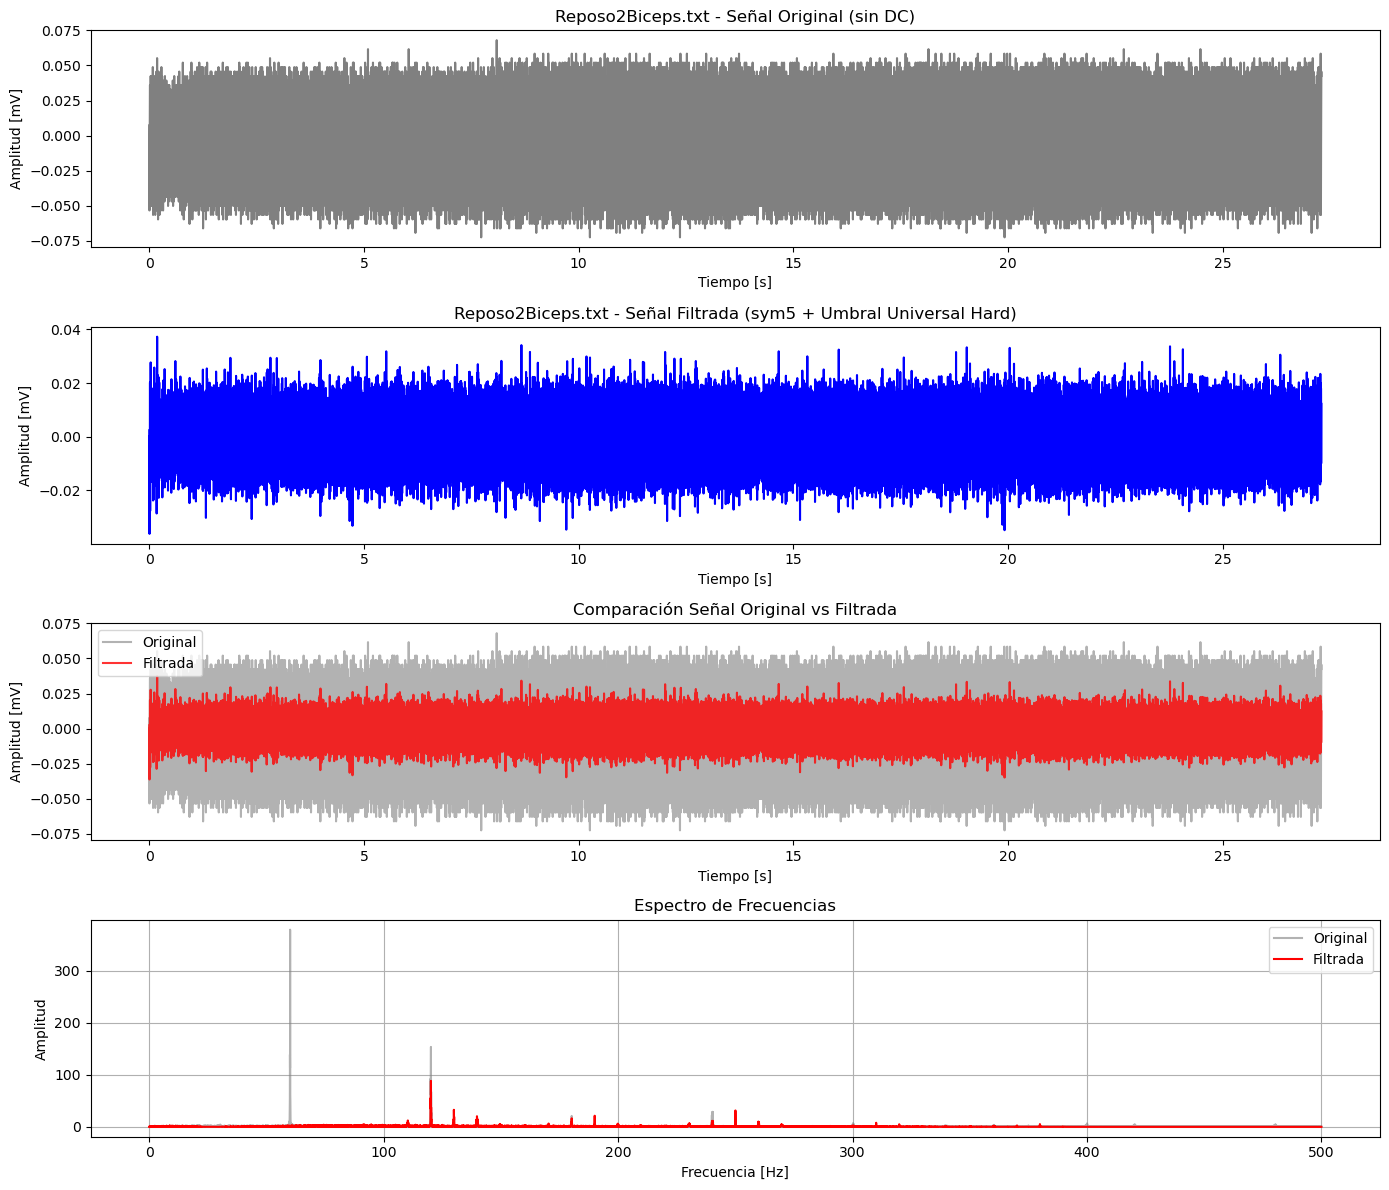

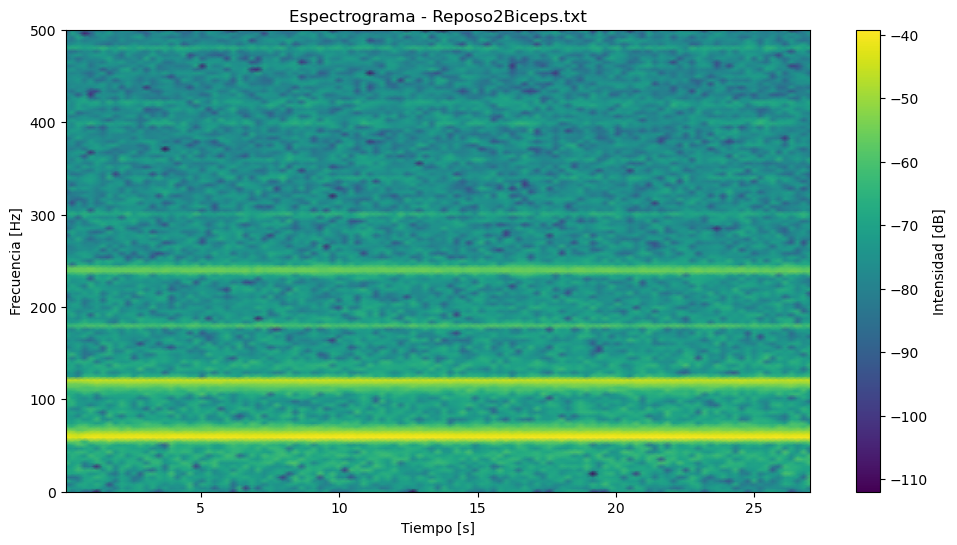

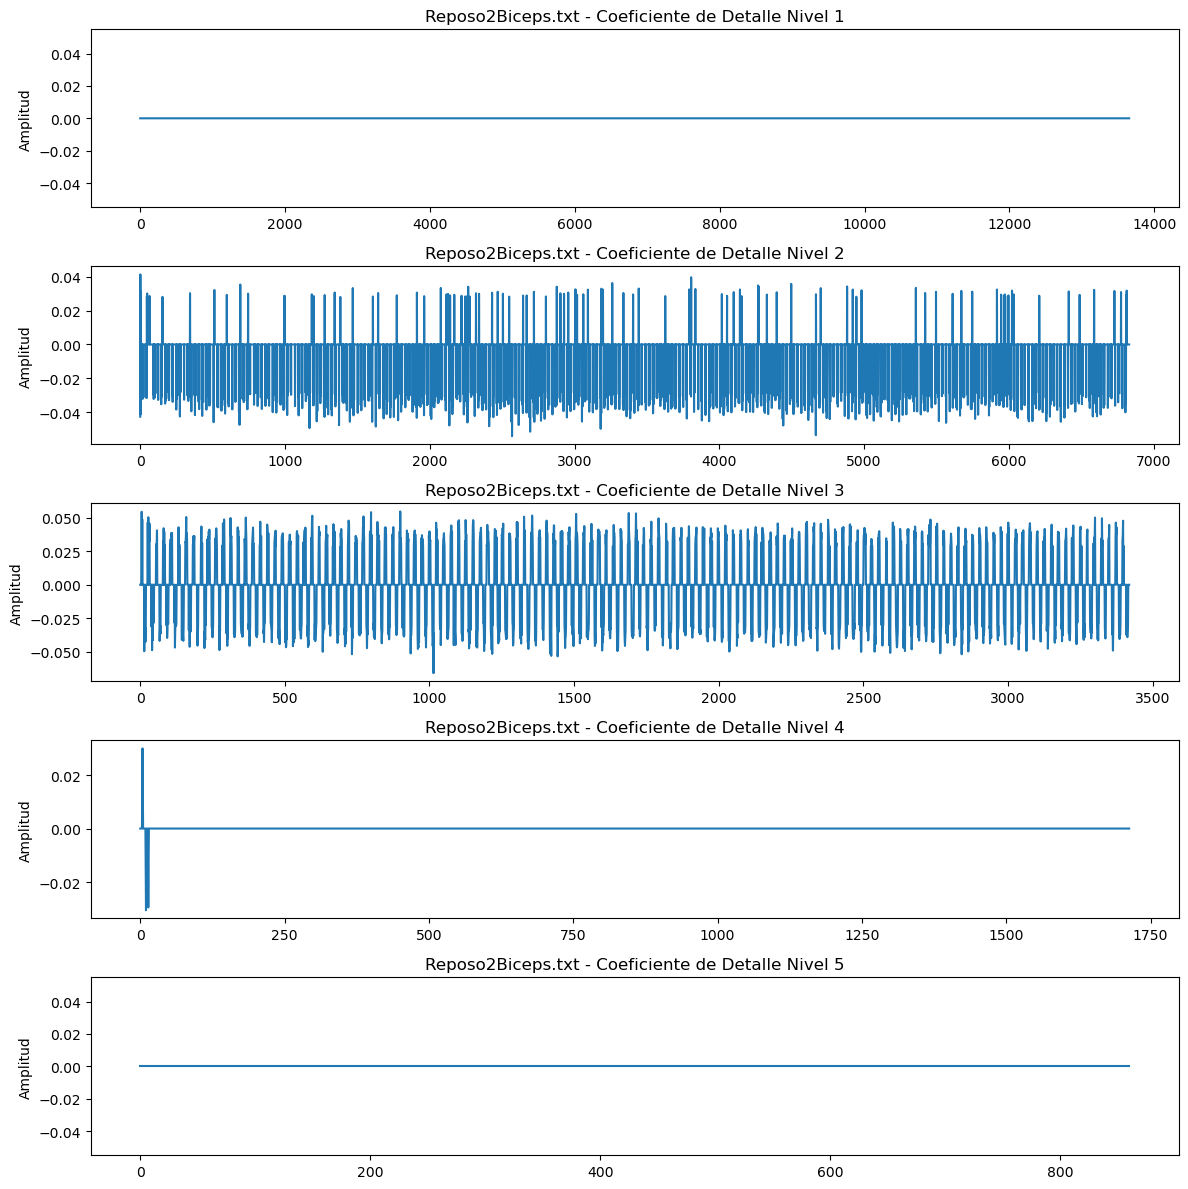


Archivo: Lento2Biceps.txt
MSE después del filtrado: 0.0003
SNR después del filtrado: 14.32 dB


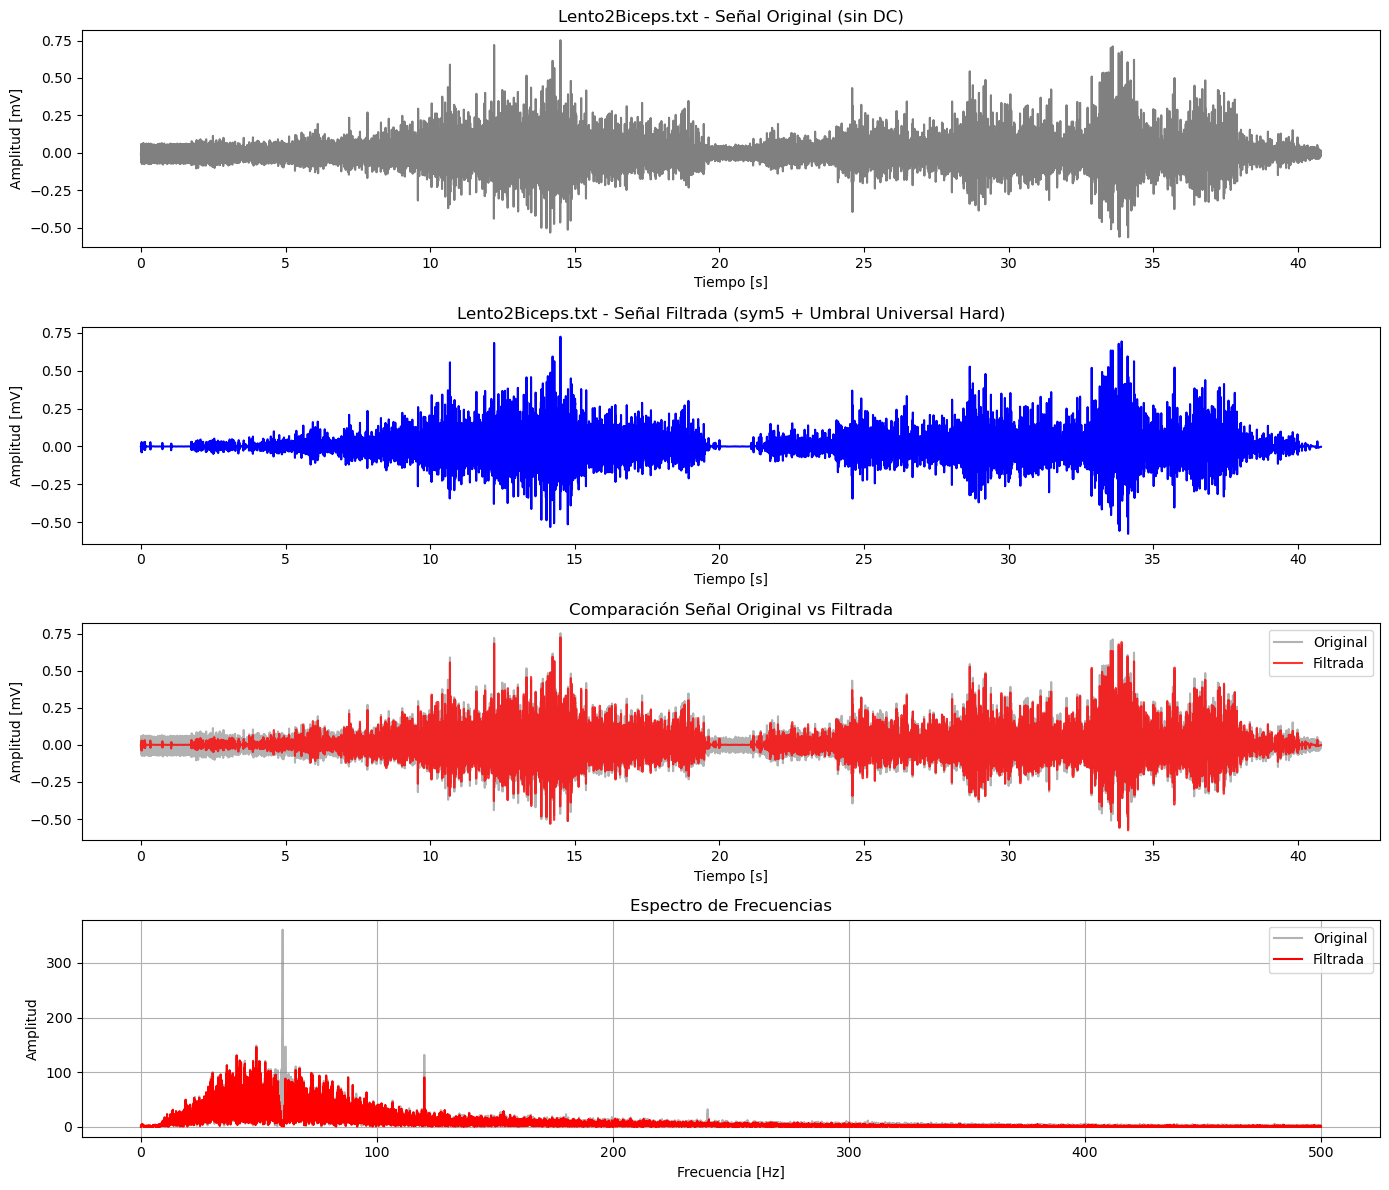

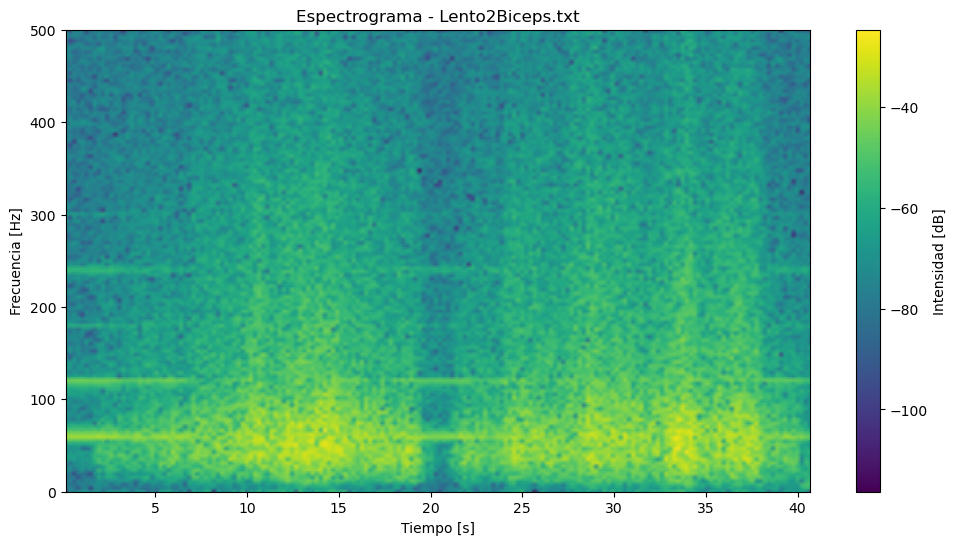

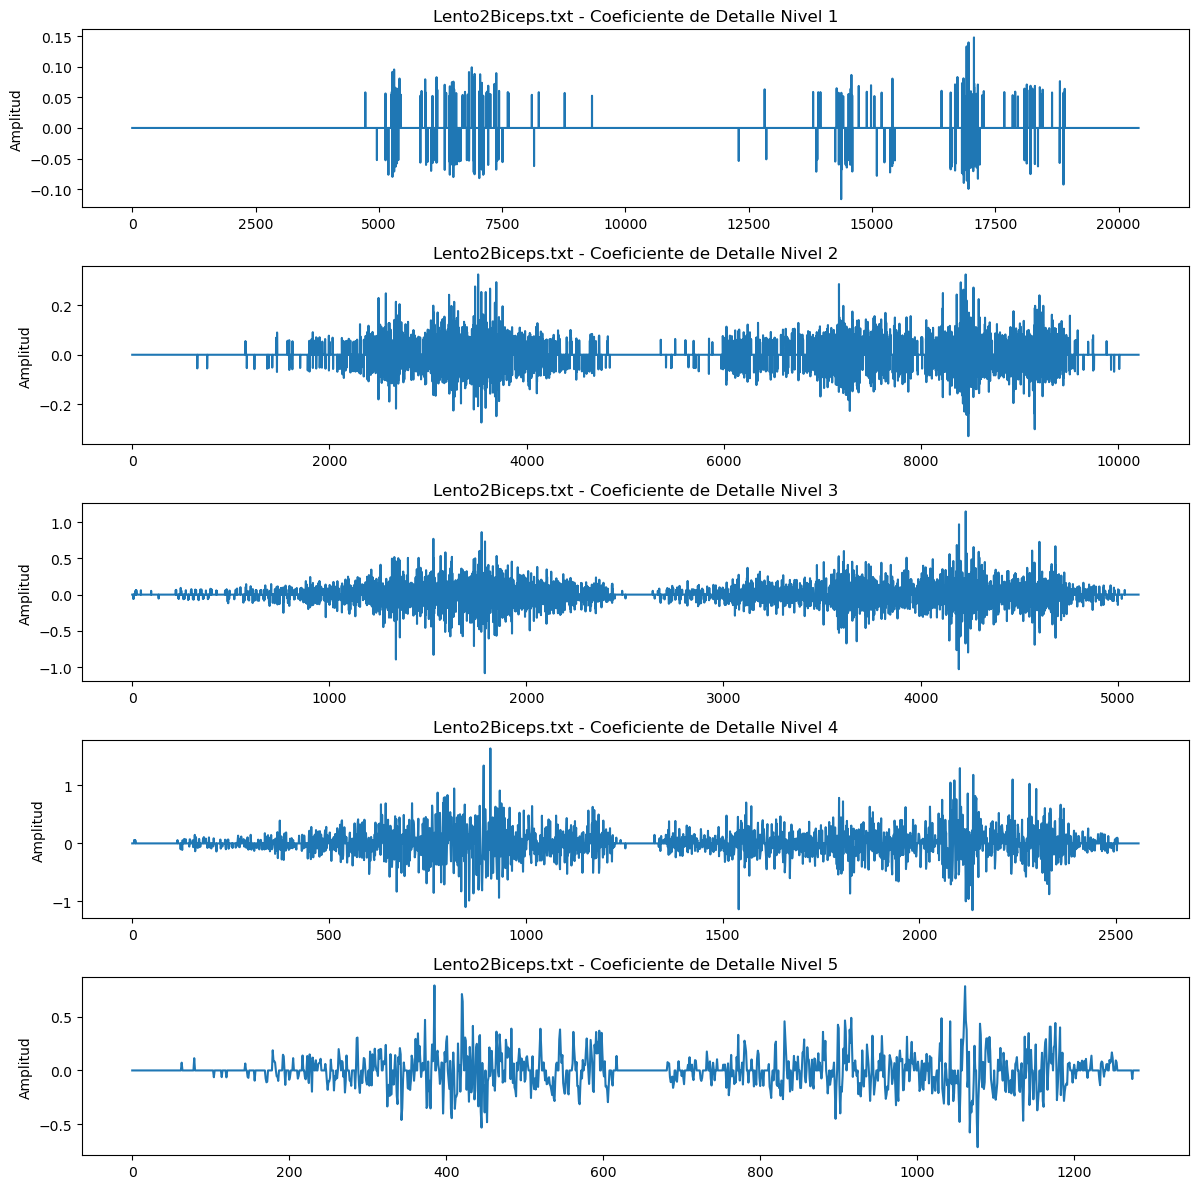


Archivo: ContraBiceps2.txt
MSE después del filtrado: 0.0006
SNR después del filtrado: 12.85 dB


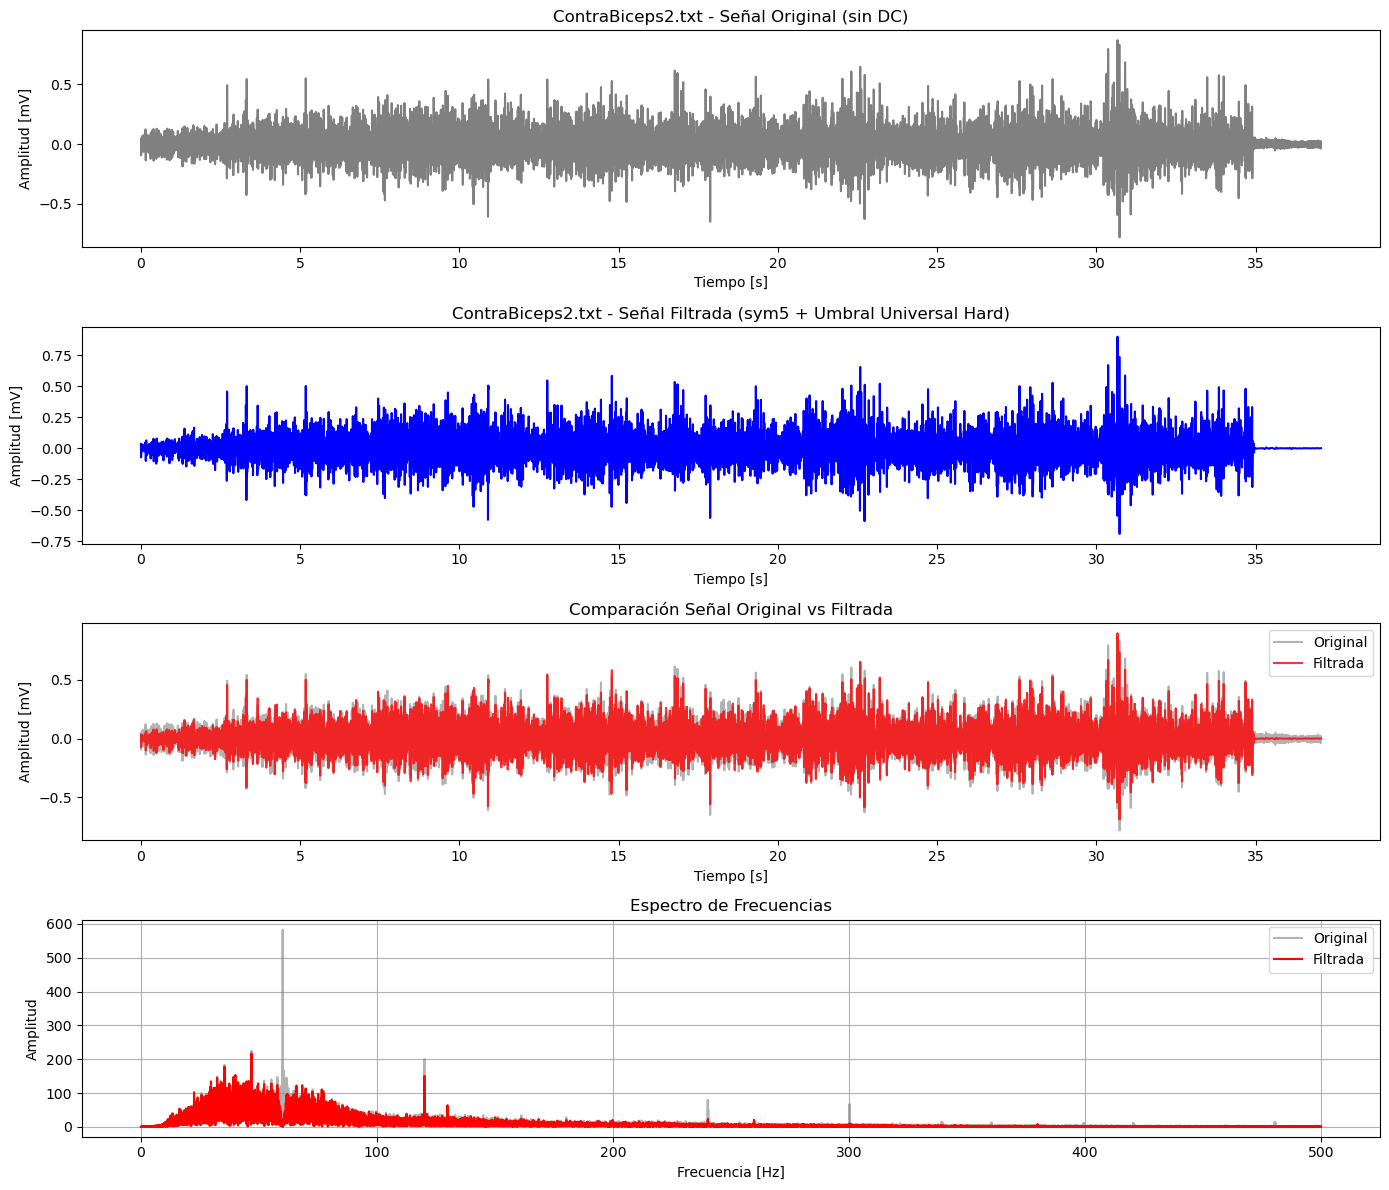

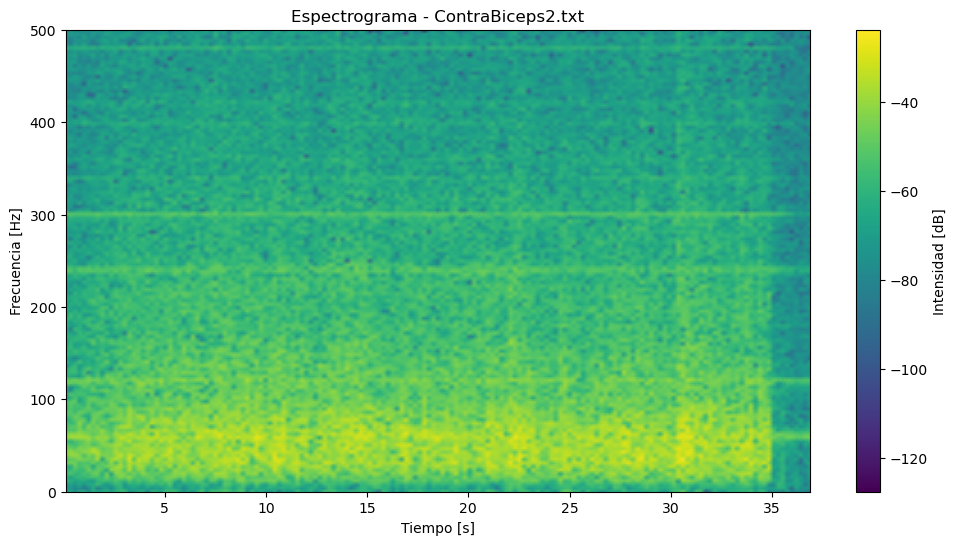

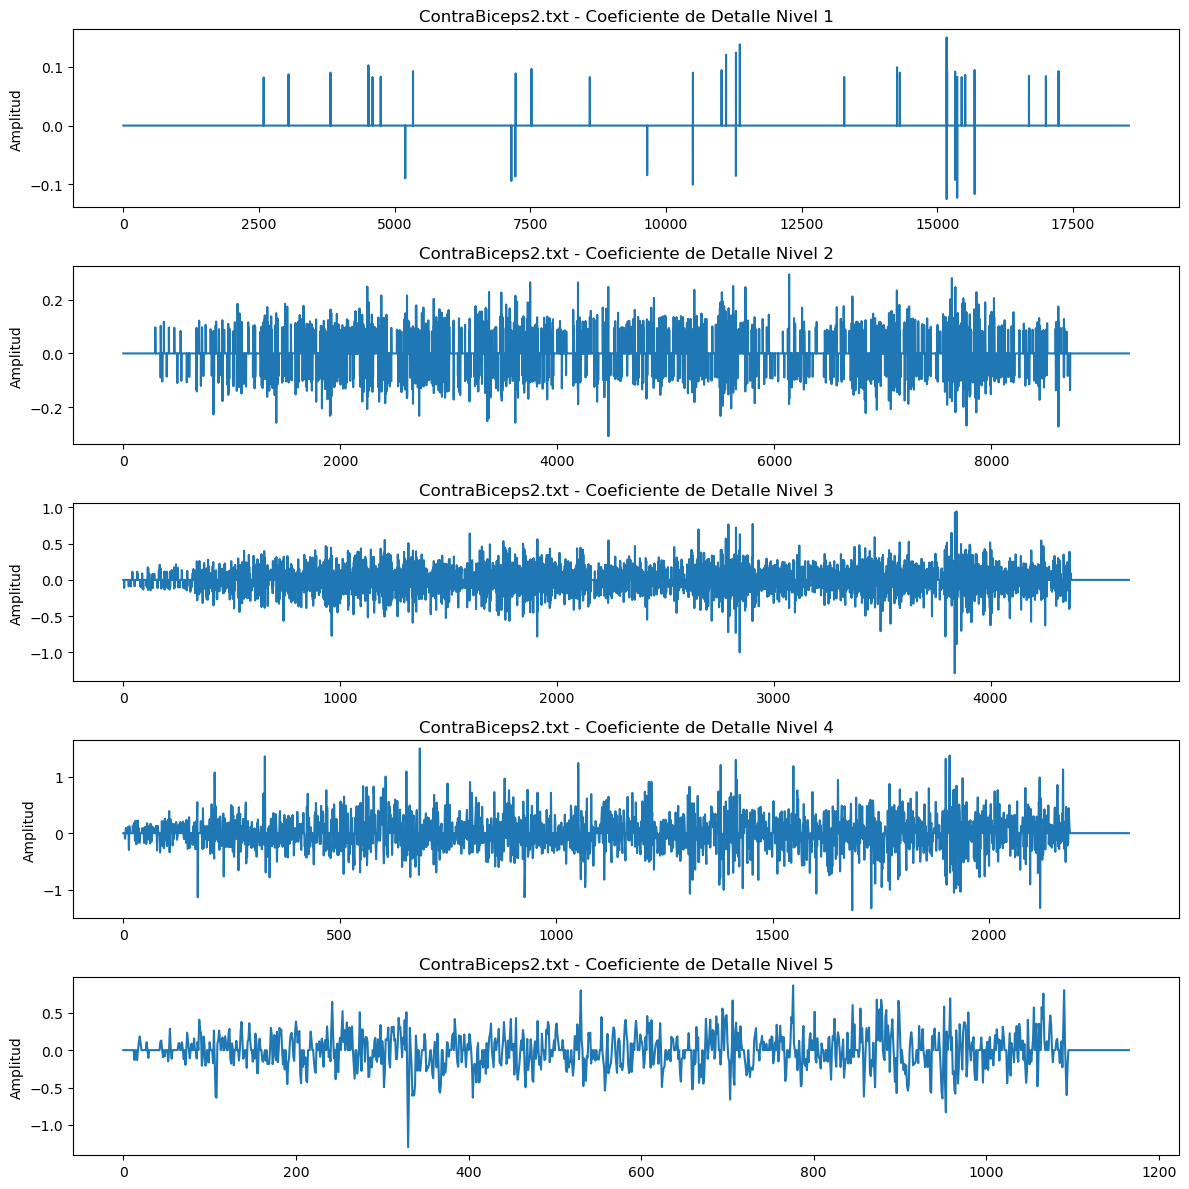

In [1]:
# =============================================================================
# FILTRADO WAVELET PARA MULTIPLES SEÑALES EMG - sym5 + Umbral Universal Hard
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from sklearn.metrics import mean_squared_error
import os

# === 1. Lista de archivos EMG ===
carpeta = r"C:\SeñalesLab3"   # ajusta si es necesario
archivos = ["Reposo2Biceps.txt", "Lento2Biceps.txt", "ContraBiceps2.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo [Hz]

# === 3. Parámetros Wavelet ===
wavelet = 'sym5'
nivel = 5

# === 4. Filtro Notch (60 Hz) ===
f0 = 60.0  # frecuencia de la red eléctrica
Q = 30.0   # factor de calidad
b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# === 5. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])
    
    EMG_raw = df["O2"].values
    t = np.arange(len(EMG_raw)) / fs

    # --- Conversión ADC → mV y quitar DC ---
    EMG_V = ((EMG_raw / ADCres) - 0.5) * VCC / Gain
    EMG_mV = EMG_V * 1000
    EMG_noDC = EMG_mV - np.mean(EMG_mV)

    # --- Filtro Notch 60 Hz ---
    EMG_notch = signal.filtfilt(b_notch, a_notch, EMG_noDC)

    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(EMG_notch, wavelet, level=nivel)

    # Estimación de ruido σ
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(EMG_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))

    # Aplicar umbral Hard (universal)
    coef_filtrados = [coeficientes[0]]
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_universal, mode='hard'))

    # Reconstrucción señal filtrada
    EMG_filtrada = pywt.waverec(coef_filtrados, wavelet)

    # --- Métricas ---
    mse_val = mean_squared_error(EMG_notch, EMG_filtrada)
    snr_val = 10 * np.log10(np.sum(EMG_notch**2) / np.sum((EMG_notch - EMG_filtrada)**2))

    print(f"\nArchivo: {archivo}")
    print(f"MSE después del filtrado: {mse_val:.4f}")
    print(f"SNR después del filtrado: {snr_val:.2f} dB")

    # =============================================================================
    # 6. GRÁFICAS
    # =============================================================================
    plt.figure(figsize=(14, 12))

    # Señal original
    plt.subplot(4, 1, 1)
    plt.plot(t, EMG_noDC, color='gray')
    plt.title(f"{archivo} - Señal Original (sin DC)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")

    # Señal filtrada
    plt.subplot(4, 1, 2)
    plt.plot(t, EMG_filtrada, color='blue')
    plt.title(f"{archivo} - Señal Filtrada (sym5 + Umbral Universal Hard)")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")

    # Comparación original vs filtrada
    plt.subplot(4, 1, 3)
    plt.plot(t, EMG_noDC, label="Original", color='gray', alpha=0.6)
    plt.plot(t, EMG_filtrada, label="Filtrada", color='red', alpha=0.8)
    plt.title("Comparación Señal Original vs Filtrada")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.legend()

    # Espectro de frecuencias
    plt.subplot(4, 1, 4)
    frecuencias = np.fft.fftfreq(len(EMG_noDC), 1/fs)
    X_original = np.fft.fft(EMG_noDC)
    X_filtrada = np.fft.fft(EMG_filtrada)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_original[:len(frecuencias)//2]),
             label='Original', color='gray', alpha=0.6)
    plt.plot(frecuencias[:len(frecuencias)//2], np.abs(X_filtrada[:len(frecuencias)//2]),
             label='Filtrada', color='red')
    plt.title("Espectro de Frecuencias")
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # =============================================================================
    # 7. Espectrograma
    # =============================================================================
    f, t_spec, Sxx = signal.spectrogram(EMG_noDC, fs)
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.title(f'Espectrograma - {archivo}')
    plt.colorbar(label='Intensidad [dB]')
    plt.show()

    # =============================================================================
    # 8. Coeficientes de detalle
    # =============================================================================
    plt.figure(figsize=(12, 12))
    for i in range(1, nivel+1):
        plt.subplot(nivel, 1, i)
        plt.plot(coef_filtrados[nivel-i+1])
        plt.title(f'{archivo} - Coeficiente de Detalle Nivel {i}')
        plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()


Archivo: Reposo2Biceps.txt
MSE después del filtrado: 0.0001
SNR después del filtrado: 3.40 dB


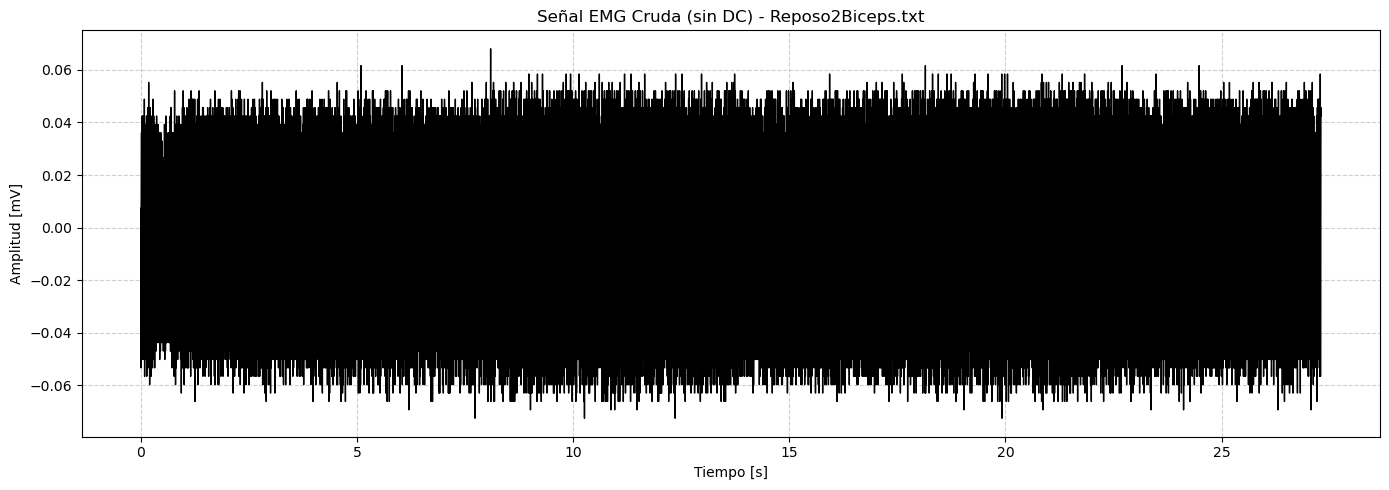

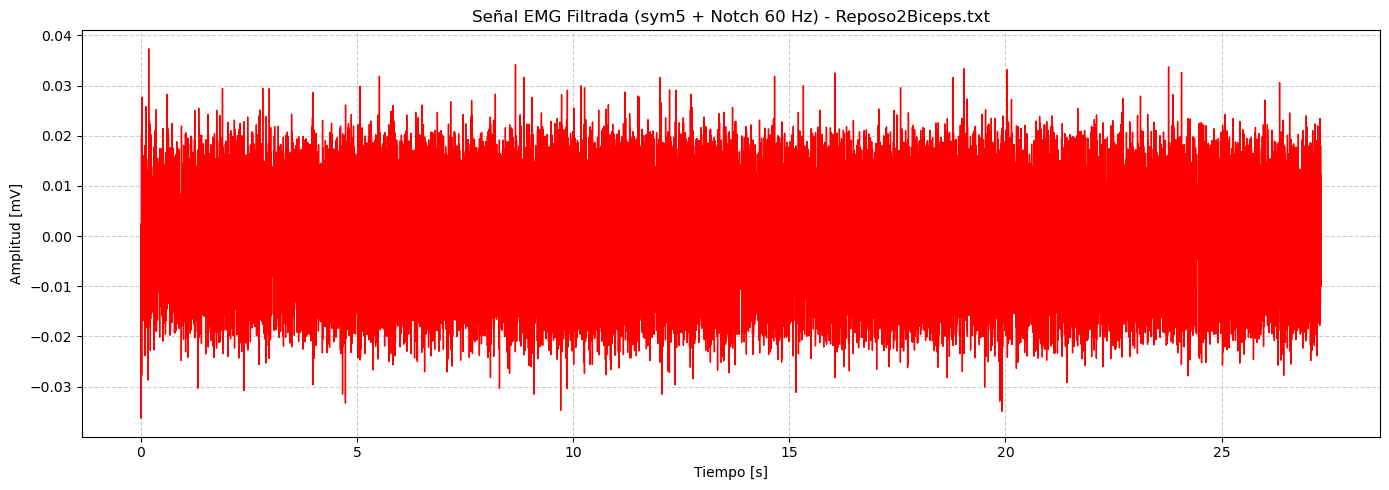


Archivo: Lento2Biceps.txt
MSE después del filtrado: 0.0003
SNR después del filtrado: 14.32 dB


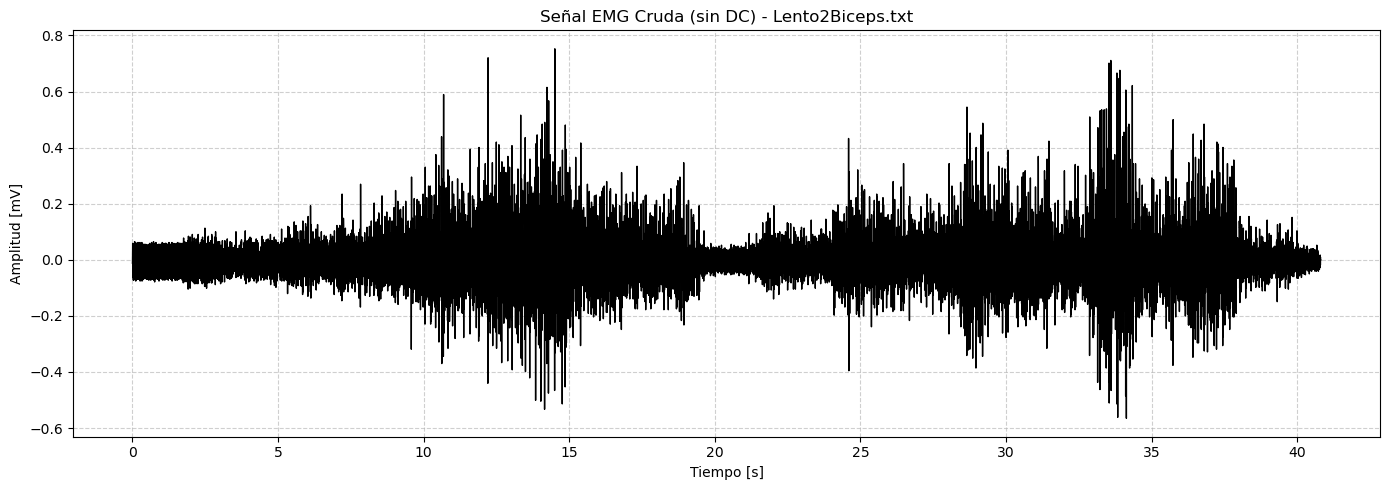

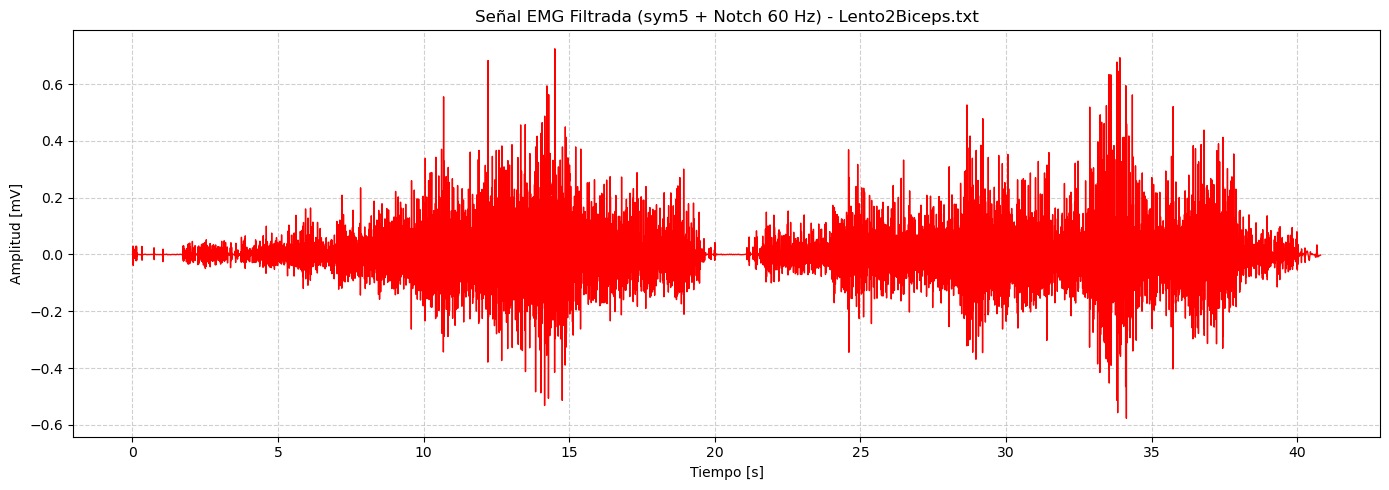


Archivo: ContraBiceps2.txt
MSE después del filtrado: 0.0006
SNR después del filtrado: 12.85 dB


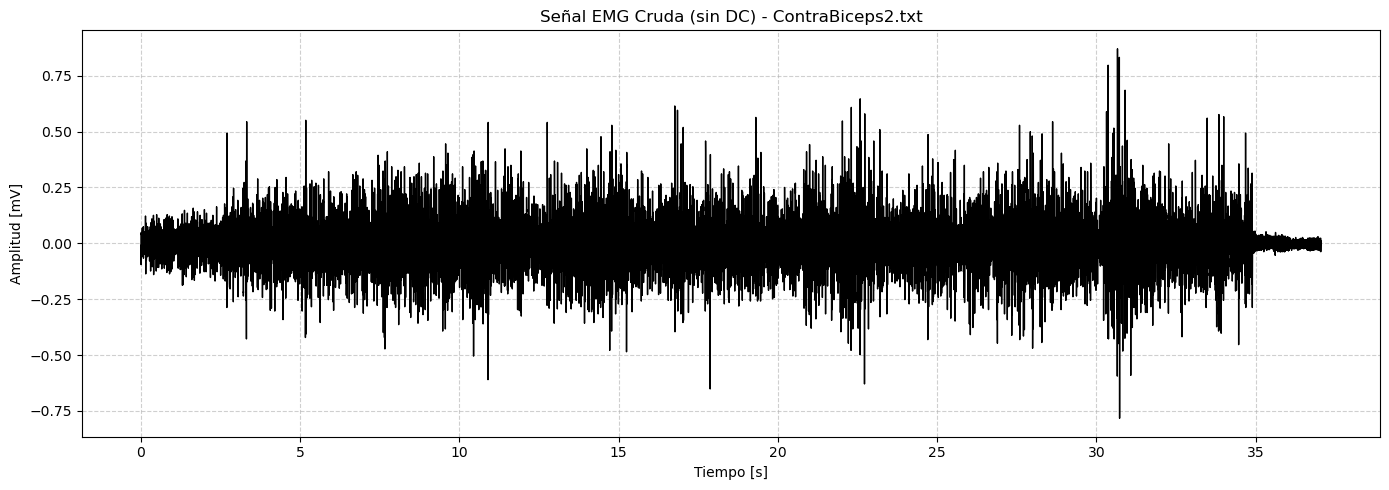

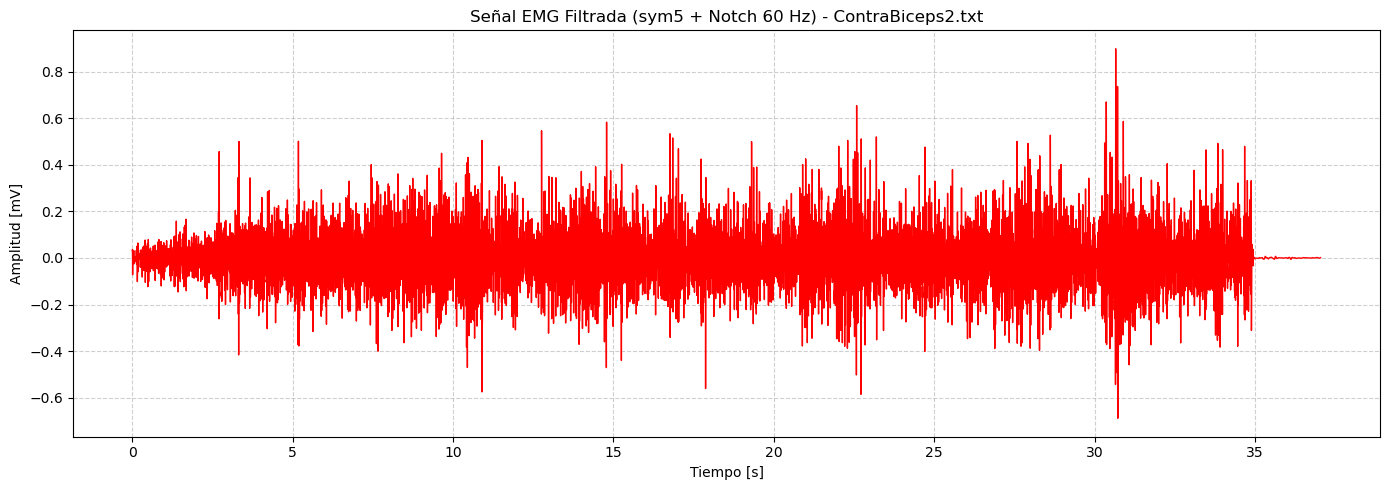

In [3]:
# =============================================================================
# FILTRADO WAVELET PARA MULTIPLES SEÑALES EMG - sym5 + Umbral Universal Hard
# (Gráficas de señal completa)
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from sklearn.metrics import mean_squared_error
import os

# === 1. Lista de archivos EMG ===
carpeta = r"C:\SeñalesLab3"
archivos = ["Reposo2Biceps.txt", "Lento2Biceps.txt", "ContraBiceps2.txt"]

# === 2. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo [Hz]

# === 3. Parámetros Wavelet ===
wavelet = 'sym5'
nivel = 5

# === 4. Filtro Notch (60 Hz) ===
f0 = 60.0
Q = 30.0
b_notch, a_notch = signal.iirnotch(f0, Q, fs)

# === 5. Procesar cada archivo ===
for archivo in archivos:
    ruta = os.path.join(carpeta, archivo)
    df = pd.read_csv(ruta, sep="\t", comment="#",
                     names=["nSeq", "I1", "I2", "O1", "O2", "A1"])

    EMG_raw = df["O2"].values
    t = np.arange(len(EMG_raw)) / fs

    # --- Conversión ADC → mV y quitar DC ---
    EMG_V = ((EMG_raw / ADCres) - 0.5) * VCC / Gain
    EMG_mV = EMG_V * 1000
    EMG_noDC = EMG_mV - np.mean(EMG_mV)

    # --- Filtro Notch 60 Hz ---
    EMG_notch = signal.filtfilt(b_notch, a_notch, EMG_noDC)

    # --- Filtrado Wavelet ---
    coeficientes = pywt.wavedec(EMG_notch, wavelet, level=nivel)
    detalle_1 = coeficientes[-1]
    sigma = np.median(np.abs(detalle_1)) / 0.6745
    n = len(EMG_notch)
    umbral_universal = sigma * np.sqrt(2 * np.log(n))

    coef_filtrados = [coeficientes[0]]
    for c in coeficientes[1:]:
        coef_filtrados.append(pywt.threshold(c, umbral_universal, mode='hard'))

    EMG_filtrada = pywt.waverec(coef_filtrados, wavelet)

    # --- Métricas ---
    mse_val = mean_squared_error(EMG_notch, EMG_filtrada)
    snr_val = 10 * np.log10(np.sum(EMG_notch**2) / np.sum((EMG_notch - EMG_filtrada)**2))

    print(f"\nArchivo: {archivo}")
    print(f"MSE después del filtrado: {mse_val:.4f}")
    print(f"SNR después del filtrado: {snr_val:.2f} dB")

    # =============================================================================
    # GRÁFICAS SEPARADAS (SEÑAL COMPLETA)
    # =============================================================================

    # --- Señal cruda (negra) ---
    plt.figure(figsize=(14, 5))
    plt.plot(t, EMG_noDC, color='black', linewidth=1)
    plt.title(f"Señal EMG Cruda (sin DC) - {archivo}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Señal filtrada (roja) ---
    plt.figure(figsize=(14, 5))
    plt.plot(t, EMG_filtrada, color='red', linewidth=1)
    plt.title(f"Señal EMG Filtrada (sym5 + Notch 60 Hz) - {archivo}")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [mV]")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
